In [1]:
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Part 1 - Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
# Load the logins json file into a DataFrame
logins_df = pd.read_json('logins.json')

In [3]:
# Look at the first few entries of the file
logins_df.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


In [4]:
logins_df.tail(3)

,login_time
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


We see that the dates in this file are from Jan. 1, 1970 to Apr 13, 1970. For our purposes, we will need to group the time by the 15-minute interval it falls in. 

In [5]:
# Add a column of 1's that will allow us to sum against
logins_df['counter'] = 1

In [6]:
# Extract the hour and minute. We will use these to define our 15-minute intervals
logins_df['hour'] = logins_df['login_time'].dt.hour
logins_df['minute'] = logins_df['login_time'].dt.minute

In [7]:
# Next we divide the minutes by 15 to know which quarter hour the login occurred
logins_df['quarter_hour'] = logins_df.minute/15
logins_df['quarter_hour'] = logins_df['quarter_hour'].apply(np.math.floor)
logins_df['quarter_hour'] = logins_df['quarter_hour']/4

In [8]:
# We can now add the hour and the decimal form of the quarter hour to obtain our interval
logins_df['interval'] = logins_df.hour + logins_df.quarter_hour

In [9]:
logins_df.head()

,login_time,counter,hour,minute,quarter_hour,interval
0,1970-01-01 20:13:18,1,20,13,0.00,20.00
1,1970-01-01 20:16:10,1,20,16,0.25,20.25
2,1970-01-01 20:16:37,1,20,16,0.25,20.25
3,1970-01-01 20:16:36,1,20,16,0.25,20.25
4,1970-01-01 20:26:21,1,20,26,0.25,20.25


In [10]:
# We group by the distinct intervals and sum to know how many logins occurred over each interval
daily = logins_df.groupby(['interval']).sum()

In [11]:
daily.head()

,counter,hour,minute,quarter_hour
interval,,,,
0.00,1439,0,9948,0.00
0.25,1547,0,33904,386.75
0.50,1525,0,56663,762.50
0.75,1482,0,77453,1111.50
1.00,1549,1549,11136,0.00


We have successfully grouped the logins into 15-minute intervals. Now we can plot the counter to have an idea of daily user login patterns. 

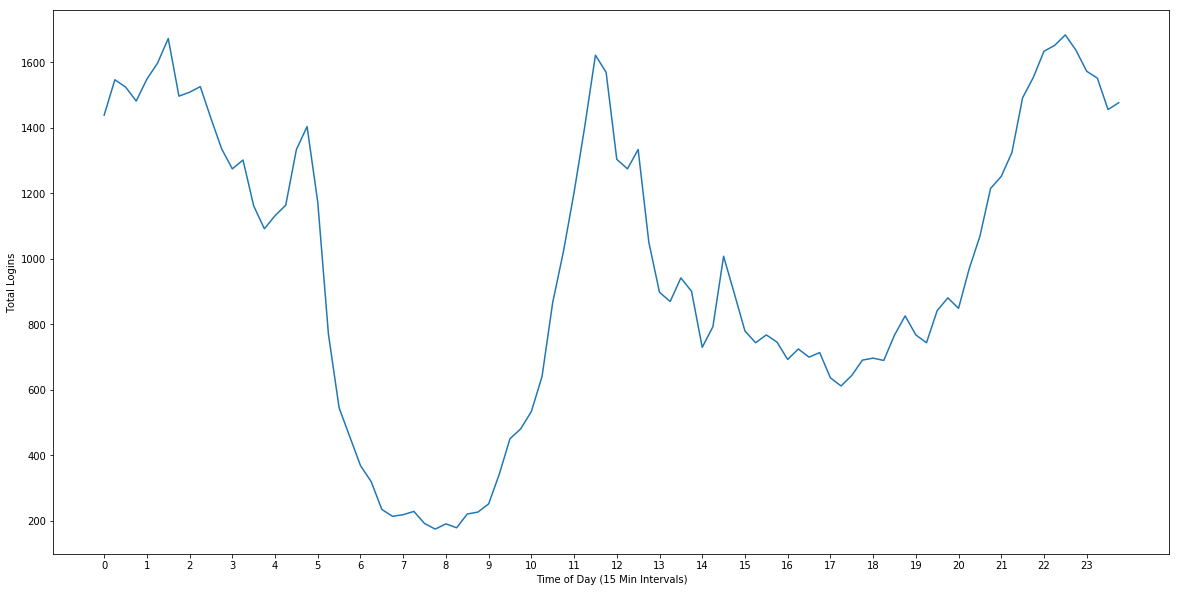

In [12]:
_=plt.figure(figsize=(20,10))
_=plt.xlabel('Time of Day (15 Min Intervals)')

_=plt.xticks(np.arange(0, 24))
_=plt.ylabel('Total Logins')
_=plt.plot(daily['counter'])
_=plt.show()

Some daily patterns immediately emerge. We see that logins are high during the evening hours between around 9pm and 5am. There's also a surge around noon. The afternoon hours experience medium traffic, while the lowest amount of traffic tends to occur between around 5:30am and 10am. 

# Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

# 1. 
What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

In order to measure the success of this experiment, we need to understand what the business need was for proposing this experiment. Obviously, it seems that the point of the experiment was not simply to increase the number of toll bridge crossings. By removing the obstacle of the toll road, the company probably hopes to obtain some or all of the following benefits:

 a. First of all, by having more drivers available in more active city, customers are more satisfied with faster pickups.

 b. Drivers are satisfied because they are able to get more rides without worrying about the toll road in the middle. If a driver wants to work while his city sleeps, he can just hop over to the other side of the bridge. 

c. The company can increase some market share by getting the rides from one city to the other that drivers may currently turn down due to the toll bridge. 

d. The company can provide the same or better level of service with fewer drivers. Fewer drivers may simplify overhead issues like taxes, employee relations, employee benefits. 

Knowing what the company's motivations are helps us to define a metric of exclusivity. In a theoretical scenario where both cities have identical activity, exclusivity could be defined as follows:

    exclusivity = home_city_operations / total_operations
    
If all the rides a driver is taking are within his home city, his exclusivity is 100%. If we combine all home city operations by all drivers in a given hour and divide that by the total number of operations in a given hour, we have the total exclusivity.

In the ideal scenario where activity in both cities is the same, we would expect the overall exclusivity above to be around 50%. This would mean that the active drivers are operating in both their home cities and the other cities at the same rate. Therefore, any drivers with an exclusivity measure close to 0.5 would be acting preferably.

However, because the activity patterns differ in both cities, we need to take this difference into account when looking at how exclusive a driver's operations are. If City A is experiencing only 10% of the activity of City B, a non-exclusive driver should be picking up about 10% of their passengers from City A. 

Therefore, you could measure overall exclusivity of all drivers and use that as a metric to see if the initiative has effected the desired results. 


# 2. 
Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

## a 
how you will implement the experiment.

For this experiment, I would split the drivers into 2 halves. The first half would get the toll bridge fee reimbursement, while the second half would be the control group and not have any reimbursement. 
    
Because the activity levels of the two cities tend to repeat over a weekly time interval, I would perform the experiment over a whole week. I would collect each driver's exclusivity measure.

## b
what statistical test(s) you will conduct to verify the significance of the observation

With the exclusivities of the two groups collected over a week, we could then plot the exclusivities of all members of each of the two test groups. I predict that we would obtain two bell curves. If we define the statistical significance level at alpha = 0.05, we could then measure the means of the two curves. Our hypothesis would be that the group that received reimbursements for the toll fees would have lower exclusivity. A p-level of less than 0.05 would then support our hypothesis, and we could confidently say that our experiment worked. 

## c
how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

If there is a statistical difference between the means of the exclusivity between both groups, I would recommend that the city operations team go through with the change. I would recommend that they measure how many reimbursements they must issue and see if it makes more sense to reimburse drivers per crossing, or to work out a deal where driver partners get some sort of monthly pass. When implementing changes like this, it is important not to inadvertently increase overhead by needing to hire new administrators to handle toll reimbursements. 

# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

# 1 
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [13]:
# load json as string
ultimate_data_challenge = json.load((open('ultimate_data_challenge.json')))

In [14]:
# load as Pandas dataframe
ultimate_data_challenge_df = pd.DataFrame(ultimate_data_challenge)

In [15]:
ultimate_data_challenge_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
ultimate_data_challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
# We are told that a user is active if the took a trip within the last 30 days. 
trip_dates = sorted(ultimate_data_challenge_df.last_trip_date.unique())

In [18]:
# We see that the last trip date is 7/1/2014
trip_dates[-1]

'2014-07-01'

In [19]:
# anyone with a last trip date >= 6/2/2014 is active
trip_dates[-30]

'2014-06-02'

We see that the last_trip_date column goes up to 7/1/2014. We are told that anyone with a last_trip_date within the last 30 days is active. Let's create a column to label active vs. inactive users. 

In [20]:
ultimate_data_challenge_df['last_trip_date'] = ultimate_data_challenge_df.last_trip_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [21]:
# Create an active label column that we will then use to train our algorithm. 
ultimate_data_challenge_df['active_lbl'] = ultimate_data_challenge_df.last_trip_date >= datetime(2014, 6, 2)

In [22]:
ultimate_data_challenge_df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_lbl
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,True
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,False
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,False
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,False
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,False


Now that we have defined a label column for the active and inactive users, let's see what proportion of the users is active. 

In [23]:
active_user_cnt = ultimate_data_challenge_df.active_lbl.sum()

In [24]:
total_user_cnt = len(ultimate_data_challenge_df)

In [25]:
active_user_cnt/total_user_cnt

0.3662

It looks like about %36.6 of users are active, assuming this sample is random and representative. 

Now let's check for missing values and handle them appropriately. 

In [26]:
ultimate_data_challenge_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [27]:
ultimate_data_challenge_df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
active_lbl                   0
dtype: int64

We see that there are three columns with null values. We could delete these columns, however, the avg_rating_of_driver column has as many as 8122 null values. This is between 15-20% of the rows. Deleting this many of the rows would yield our algorithms ineffective. Therefore we need to impute some value. Based on the quartiles of the columns above, it seems that most ratings are 5.0. For this reason, I believe it is safe to simply replace the null values with 5.0 for both avg_rating columns. 



In [28]:
ultimate_data_challenge_df.avg_rating_by_driver.fillna(5.0, inplace=True)

In [29]:
ultimate_data_challenge_df.avg_rating_of_driver.fillna(5.0, inplace=True)

This leaves us with just the phone column containing null values. We see below that there are iPhones and Androids, and empty values. It is tempting to delete the rows with the null values especially because there are only around 400 such rows. However, maybe the null values signify non-standard phones, and perhaps people with these phone tend to be more active or less active. 

Therefore, I propose that we do a one-hot encoding of the phone column. That way, we will have numerical values for the type of phone, and the nones will be 0 in all phone columns. 

In [30]:
ultimate_data_challenge_df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [31]:
# use pd.concat to join the new columns with your original dataframe
ultimate_data_challenge_df = pd.concat([ultimate_data_challenge_df,pd.get_dummies(ultimate_data_challenge_df['phone'], prefix='phone')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
ultimate_data_challenge_df.drop(['phone'],axis=1, inplace=True)

In [32]:
ultimate_data_challenge_df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_lbl,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,2014-01-25,15.4,4,True,46.2,True,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,2014-01-29,0.0,0,False,50.0,False,1,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,2014-01-06,0.0,3,False,100.0,False,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,2014-01-10,20.0,9,True,80.0,True,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,2014-01-27,11.8,14,False,82.4,False,1,0
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,2014-01-09,0.0,2,True,100.0,True,0,1
6,3.95,4.0,5.0,1.00,Astapor,2014-01-25,2014-01-24,0.0,1,False,100.0,False,1,0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,2014-01-28,0.0,2,False,100.0,False,0,1
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,2014-01-21,0.0,2,False,100.0,False,1,0
9,2.37,5.0,5.0,1.00,Winterfell,2014-01-05,2014-01-03,0.0,1,False,0.0,False,1,0


The city column also looks like a good candidate for one-hot-encoding. We see below that there are 3 unique cities. We perform the one-hot-encoding. 

In [33]:
ultimate_data_challenge_df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [34]:
# use pd.concat to join the new columns with your original dataframe
ultimate_data_challenge_df = pd.concat([ultimate_data_challenge_df,pd
                                        .get_dummies(ultimate_data_challenge_df['city'], 
                                                     prefix='city', drop_first=True)],axis=1)

# now drop the original 'country' column (you don't need it anymore)
ultimate_data_challenge_df.drop(['city'],axis=1, inplace=True)

Initially, it's hard to say what information the signup date may add to our algorithm. However, it might make sense to grab the day of the week that the user signed up. Perhaps people who signed up on certain days of the week tended to remain more active. It's reasonable to think that weekend users who go out to party may be more likely to remain active in six months time. Therefore, we will make a column for the day of the week the user signed up, and remove the signup date and last trip date. 

In [35]:
ultimate_data_challenge_df['signup_date'] = ultimate_data_challenge_df.signup_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [36]:
# Add 'dow' and 'doy'
ultimate_data_challenge_df['signup_dow'] = ultimate_data_challenge_df['signup_date'].dt.dayofweek # adding day of week as a feature

In [37]:
ultimate_data_challenge_df['weekend_signup'] = ultimate_data_challenge_df['signup_dow'] >= 5

In [38]:
ultimate_data_challenge_df = ultimate_data_challenge_df.drop(['signup_date', 'last_trip_date', 'signup_dow'], axis=1)

In [39]:
ultimate_data_challenge_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_lbl,phone_Android,phone_iPhone,city_King's Landing,city_Winterfell,weekend_signup
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,True,0,1,1,0,True
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,False,1,0,0,0,False
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,False,0,1,0,0,False
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,True,0,1,1,0,False
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,False,1,0,0,1,False


# 2
Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

For this challenge, I will use a Naive Bayes classifier. This is a classification problem, as we ultimately want to find out if the user will be still active (True), or not (False). I chose the Naive Bayes algorithm because we can apply it to our data without normalizing all the data. 

To start, I will choose a subset to act as our test data. This data will be removed and will in no way influence the training of our algorithm. 

In [40]:
# Sample size - in this case ~10%
size = int(total_user_cnt / 10)

# The row indices to skip - make sure 0 is not included to keep the header!
train = ultimate_data_challenge_df.iloc[:(total_user_cnt - size)]
len(train)


45000

In [41]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_lbl,phone_Android,phone_iPhone,city_King's Landing,city_Winterfell,weekend_signup
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,True,0,1,1,0,True
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,False,1,0,0,0,False
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,False,0,1,0,0,False
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,True,0,1,1,0,False
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,False,1,0,0,1,False


In [42]:
test = ultimate_data_challenge_df.iloc[(total_user_cnt - size):]
len(test)

5000

In [43]:
# separate the features from the labels
train_labels = train.active_lbl
train = train.drop(['active_lbl'], axis=1)

test_labels = test.active_lbl
test = test.drop(['active_lbl'], axis=1)

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [45]:
clf.fit(train, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
predictions = clf.predict(test)

In [47]:
probs = clf.predict_proba(test)[:,1]

In [48]:
len(predictions)

5000

In [49]:
test_labels = pd.DataFrame(test_labels)

In [50]:
probs

array([0.33938968, 0.06726743, 0.37297875, ..., 0.05598671, 0.34174518,
       0.05868774])

In [51]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels, probs)

In [52]:
test_labels['prediction_prob'] = probs

In [53]:
test_labels['predictions'] = predictions

In [54]:
test_labels.head()

,active_lbl,prediction_prob,predictions
45000,False,0.339390,False
45001,False,0.067267,False
45002,True,0.372979,False
45003,True,0.046003,False
45004,False,0.012278,False


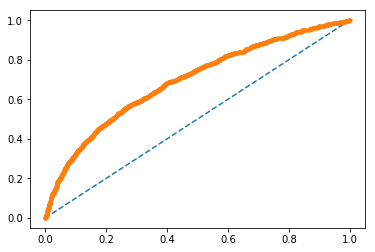

In [55]:
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [56]:
# calculate AUC
auc = roc_auc_score(test_labels.active_lbl, probs)
print('AUC: %.3f' % auc)

AUC: 0.694


In [57]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(train.columns, neg_class_prob_sorted[:10]))
print(np.take(train.columns, pos_class_prob_sorted[:10]))

Index(['city_King's Landing', 'ultimate_black_user', 'weekend_signup',
       'phone_Android', 'city_Winterfell', 'phone_iPhone', 'avg_surge',
       'trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_rating_by_driver'],
      dtype='object')
Index(['phone_Android', 'weekend_signup', 'city_King's Landing',
       'city_Winterfell', 'ultimate_black_user', 'phone_iPhone', 'avg_surge',
       'trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_rating_by_driver'],
      dtype='object')
